In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from transforms3d.euler import euler2mat
import colorsys

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

# Введение
На сегодняшней практике продолжим работать с фундаментальной матрицей.
Для этого нам понадобится усеченной пирамидой с предыдущей практики:

In [2]:
VERTICES_GT = np.array([
    [-1.5, 1, -1.5],
    [1.5, 1, -1.5],
    [1.5, 1, 1.5],
    [-1.5, 1, 1.5],
    [-1, -1, -1],
    [1, -1, -1],
    [1, -1, 1],
    [-1, -1, 1]
])

EPS = 1e-5

Ширина и высота кадра, а также матрица проекции камеры `PROJ_MAT` $3\times3$,
которые будем использовать для отрисовки изображений:

In [3]:
IMG_WIDTH = 800
IMG_HEIGHT = 600

fx = fy = 400
cx = IMG_WIDTH / 2
cy = IMG_HEIGHT / 2

PROJ_MAT = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
])

Также воспользуемся вспомогательными функциями:

In [4]:
def generate_colors(count):
    hues = np.linspace(0, 1, count, endpoint=False)
    colors = []
    for h in hues:
        colors.append(colorsys.hsv_to_rgb(h, 1, 1))
    return colors


VERTICES_COLORS = generate_colors(len(VERTICES_GT))

def draw_pyramid(points2d, edge_color=(0, 1, 0), vertices_colors=VERTICES_COLORS):
    img = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
    int_tuples = [tuple(map(int, p)) for p in points2d]
    point_size = 5
    edge_thickness = 2
    edges = [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 0],
        [4, 5],
        [5, 6],
        [6, 7],
        [7, 4],
        [0, 4],
        [1, 5],
        [2, 6],
        [3, 7]
    ]
    for i, j in edges:
        u = int_tuples[i]
        v = int_tuples[j]
        cv2.line(img, u, v, edge_color, edge_thickness)
    for u, color in zip(int_tuples, vertices_colors):
        cv2.circle(img, u, point_size, color, -1)
    return img

def project_points3d(points3d, pmat):
    points4d = np.hstack((
        points3d,
        np.ones((points3d.shape[0], 1))
    ))
    points4d = (pmat @ points4d.T).T
    points4d /= points4d[:, 2].reshape(-1, 1)
    return points4d[:, :2]

def rmat_and_tvec_to_mat3x4(rmat, tvec):
    mat = np.zeros((3, 4))
    mat[:, :3] = rmat
    mat[:, 3] = tvec
    return mat

def camera_pose_3x4_to_view_mat(pose):
    rmat_inv = pose[:, :3].T
    tvec = -rmat_inv @ pose[:, 3]
    return rmat_and_tvec_to_mat3x4(rmat_inv, tvec)

def point_to_homogeneous(point):
    return np.append(point, 1.0)

Также воспользуемся методами для вычисления фундаментальной матрицы, эпиполей и эпиполярных линий из позиций камер, которые мы разобрали на предыдущей практике:

In [5]:

def compute_epipole_from_poses(camera_pos_1, camera_pos_2, proj_mat):
    view_proj_1 = proj_mat @ camera_pose_3x4_to_view_mat(camera_pos_1)
    camera_center_2 = point_to_homogeneous(camera_pos_2[:, 3])

    epipole = view_proj_1 @ camera_center_2
    if np.abs(epipole[2]) < EPS:
        epipole[2] = 0.0
    else:
        epipole /= epipole[2]
    return epipole

def draw_epipole(image, epipole, radius=5, color=(1, 1, 1)):
    output_img = image.copy()
    if epipole[2] < EPS:
        return output_img
    pt2d = tuple(epipole[:2].astype(int))
    cv2.circle(output_img, pt2d, radius,
               color, thickness=cv2.FILLED)
    return output_img

def compute_epipolar_line_from_poses(camera_pos_1, camera_pos_2,
                                     pnt2d_camera2, proj_mat):
    view_proj_2 = proj_mat @ camera_pose_3x4_to_view_mat(camera_pos_2)
    view_proj_pseudo_inv_2 = view_proj_2.T @ np.linalg.inv(view_proj_2 @ view_proj_2.T)
    pnt_on_ray = view_proj_pseudo_inv_2 @ point_to_homogeneous(pnt2d_camera2)

    view_proj_1 = proj_mat @ camera_pose_3x4_to_view_mat(camera_pos_1)
    pnt_on_epiline = view_proj_1 @ pnt_on_ray
    pnt_on_epiline /= pnt_on_epiline[2]

    epipole_1 = compute_epipole_from_poses(camera_pos_1, camera_pos_2, proj_mat)
    line = np.cross(pnt_on_epiline[:3], epipole_1)
    line /= np.linalg.norm(line)
    return line

def _draw_epipolar_line(image, line, thickness=2, color=(0.0, 0.0, 1.0)):
    h, w = image.shape[:2]
    pt1 = (0, int(-line[2] / line[1]))
    pt2 = (w, int((-line[2] - line[0] * w) / line[1]))
    cv2.line(image, pt1, pt2, color, thickness=thickness)

def draw_epipolar_lines(image, lines):
    output_img = image.copy()
    for line in lines:
        _draw_epipolar_line(output_img, line)
    return output_img

def compute_fundamental_mat_from_poses(camera_pose_1, camera_pose_2, proj_mat):
    view_proj_1 = proj_mat @ camera_pose_3x4_to_view_mat(camera_pose_1)
    view_proj_2 = proj_mat @ camera_pose_3x4_to_view_mat(camera_pose_2)
    epipole_1 = compute_epipole_from_poses(camera_pose_1, camera_pose_2, proj_mat)
    cross_mat = np.array([
        [0.0, -epipole_1[2], epipole_1[1]],
        [epipole_1[2], 0.0, -epipole_1[0]],
        [-epipole_1[1], epipole_1[0], 0.0]
    ])
    view_proj_pseudo_inv_2 = view_proj_2.T @ np.linalg.inv((view_proj_2 @ view_proj_2.T))
    f_mat = cross_mat @ view_proj_1 @ view_proj_pseudo_inv_2
    f_mat /= f_mat[2, 2]
    return f_mat

def compute_epipole(f_mat):
    u, s, v = np.linalg.svd(f_mat)
    epipole = v[-1]

    if np.abs(epipole[2]) < EPS:
        epipole[2] = 0.0
    else:
        epipole /= epipole[2]
    return epipole

def compute_epipolar_line(f_mat, point2d):
    line = f_mat @ point_to_homogeneous(point2d)
    line /= np.linalg.norm(line)
    return line


In [6]:
camera_pose_1 = rmat_and_tvec_to_mat3x4(
    euler2mat(np.deg2rad(-10.0), np.deg2rad(15.0), np.deg2rad(5.0)),
    np.array([-1.0, 0.0, -4]))
view_proj_1 = PROJ_MAT @ camera_pose_3x4_to_view_mat(camera_pose_1)
points2d_1 = project_points3d(VERTICES_GT, view_proj_1)
img_1 = draw_pyramid(points2d_1)

camera_pose_2 = rmat_and_tvec_to_mat3x4(
    euler2mat(np.deg2rad(-10.0), np.deg2rad(30.0), np.deg2rad(5.0)),
    np.array([-4, -1.0, -5]))
view_proj_2 = PROJ_MAT @ camera_pose_3x4_to_view_mat(camera_pose_2)
points2d_2 = project_points3d(VERTICES_GT, view_proj_2)
img_2 = draw_pyramid(points2d_2)



# Задание 1
1. Используя функцию `compute_fundamental_mat_from_poses` посчитайте фундаментальную матрицу $F$ для пары камер в позициях `camera_pose_1` и `camera_pose_2`.
2. Проверьте выполнение свойств фундаментальной матрицы:
    - $F^T$ является фундаментальной матрицей для пары камер в позициях `camera_pose_2` и `camera_pose_1`
    - $detF = 0$
3. Посчитайте эпиполи и проверьте, что они являются нулями $F$

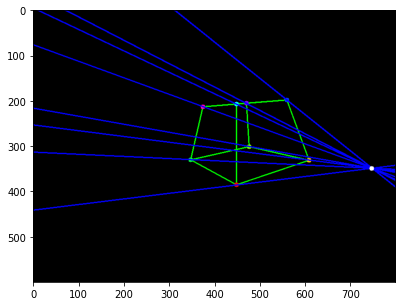

In [66]:
fmat = compute_fundamental_mat_from_poses(camera_pose_1, camera_pose_2, PROJ_MAT)
for i in range(len(points2d_2)):
    assert np.dot(point_to_homogeneous(points2d_2[i]), compute_epipolar_line(fmat.T, points2d_1[i])) < EPS

assert np.linalg.det(fmat) < EPS

assert np.all(abs(compute_epipole_from_poses(camera_pose_2, camera_pose_1, PROJ_MAT) - compute_epipole(fmat)) < EPS)

res = img_2.copy()
epipole = compute_epipole(fmat)
epipolar_lines = [compute_epipolar_line(fmat.T, points2d_1[i]) for i in range(len(points2d_1))]
res = draw_epipolar_lines(res, epipolar_lines)
res = draw_epipole(res, epipole)
plt.imshow(res)
plt.show()

# Задание 2
1. Используйте функцию `cv2.findFundamentalMat` для вычисления фундаментальной матрицы по двумерным соответствиям `points2d_1` и `points2d_2`. Сравните результаты работы различных методов вычисления (7-точечный, 8-точечный, RANSAC).
2. Добавьте шум к спроецированным уголкам пирамиды с помощью функции `add_noize_to_points` и используйте их для вычисления фундаментальной матрицы, эпиполей и эпиполярных линий.
3. Нарисуйте эпиполи и эпиполярные линии и посмотрите, как они будут выглядеть в зависимости от значений шума.


In [44]:
def add_noize_to_points(points, noise_scale):
    return points + np.random.normal(scale=noise_scale, size=points.shape)

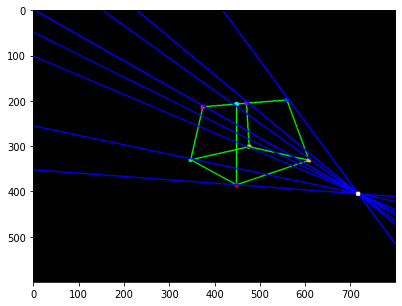

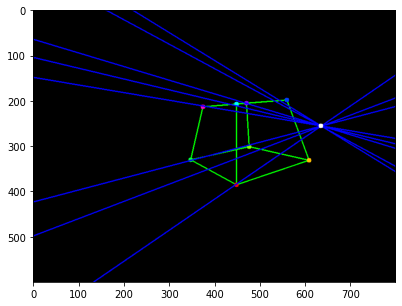

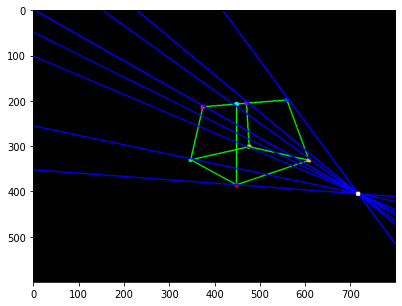

In [59]:
np.random.seed(52)
ps1 = add_noize_to_points(points2d_1, 3)
ps2 = add_noize_to_points(points2d_2, 3)

for m in [cv2.FM_7POINT, cv2.FM_8POINT, cv2.FM_RANSAC]:
    fmat = cv2.findFundamentalMat(ps1, ps2, m)[0]
    res = img_2.copy()
    epipole = compute_epipole(fmat.T)
    epipolar_lines = [compute_epipolar_line(fmat, ps1[i]) for i in range(len(ps1))]
    res = draw_epipolar_lines(res, epipolar_lines)
    res = draw_epipole(res, epipole)
    plt.imshow(res)
    plt.show()


# Задание 3
Используйте функцию `cv2.findEssentialMat` для вычисления существенной матрицы по двумерным соответствиям `points2d_1` и `points2d_2`. Сравните результаты работы различных методов вычисления.

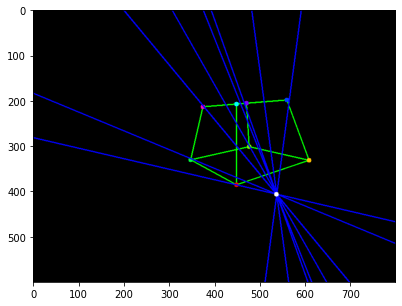

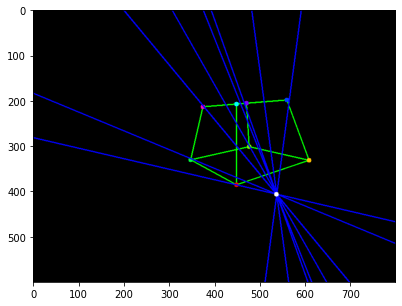

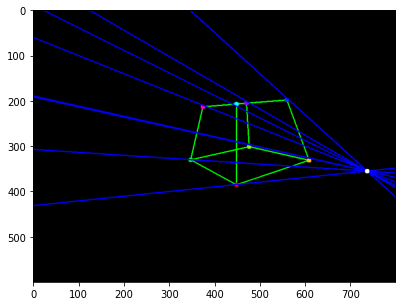

In [61]:
np.random.seed(52)
ps1 = add_noize_to_points(points2d_1, 3)
ps2 = add_noize_to_points(points2d_2, 3)

for m in [cv2.FM_7POINT, cv2.FM_8POINT, cv2.FM_RANSAC]:
    emat = cv2.findEssentialMat(ps1, ps2, PROJ_MAT, m)[0]
    fmat = np.linalg.inv(PROJ_MAT.T) @ emat @ np.linalg.inv(PROJ_MAT)
    res = img_2.copy()
    epipole = compute_epipole(fmat.T)
    epipolar_lines = [compute_epipolar_line(fmat, ps1[i]) for i in range(len(ps1))]
    res = draw_epipolar_lines(res, epipolar_lines)
    res = draw_epipole(res, epipole)
    plt.imshow(res)
    plt.show()

# Задание 4
1. Напишите функцию `compute_fundamental_mat` для вычисления фундаментальной матрицы по двумерным соответствиям.
2. Напишите функци `compute_essential_mat` для вычисления фундаментальной матрицы по двумерным соответствиям.

In [44]:
def compute_fundamental_mat(pnts2d_1, pnts2d_2):
    A = np.zeros([len(pnts2d_1), 9])
    for i in range(len(pnts2d_1)):
        p1 = pnts2d_1[i]
        p2 = pnts2d_2[i]
        A[i] = np.array([
            p2[0] * p1[0], p2[0] * p1[1], p2[0],
            p2[1] * p1[0], p2[1] * p1[1], p2[1],
            p1[0],         p1[1],         1.0,
        ])
    u, s, v = np.linalg.svd(A)
    f = v[7].reshape([3, 3])
    u, s, v = np.linalg.svd(f)
    s = np.diag([s[0], s[1], 0.0])
    f = u @ s @ v
    return f


def compute_essential_mat(pnts2d_1, pnts2d_2, proj_mat):
    fmat = compute_fundamental_mat(pnts2d_1, pnts2d_2)
    return proj_mat.T @ fmat @ proj_mat

# Задание 5
1. Воспользуйтесь функцией `cv2.findHomography` для вычисления гомографии между двумерными соответствиями.
2. Поэкспериментируйте с различными позициями камеры и с различным уровнем шума и попробуйте отфильтровать вырожденные случаи с помощью фундаментальной матрицы.

In [ ]:
# TODO implement

# Задание 6
1. Напишите функцию `essential_mat_to_camera_view_matrices` для вычисления 4-х возможных матриц параметров камеры из существенной матрицы.
2. Воспользуйтесь функцией `triangulate_points` для выбора одного из 4-х решений.

In [22]:
def _triangulate_point(points2d, view_proj_list):

    m = np.vstack([[
            point2d[0] * view_proj[3] - view_proj[0],
            point2d[1] * view_proj[3] - view_proj[1],
        ] for point2d, view_proj in zip(points2d, view_proj_list)])
    u, s, vh = np.linalg.svd(m)
    point3d = vh[-1, :].flatten()
    return point3d[:3] / point3d[-1]


def triangulate_points(points2d_1, points2d_2, camera_pose_1, camera_pose_2, proj_mat):
    view_proj_1 = proj_mat @ np.linalg.inv(camera_pose_1)
    view_proj_2 = proj_mat @ np.linalg.inv(camera_pose_2)
    assert(len(points2d_1) == len(points2d_2))
    points3d = []
    for pt2d_1, pt2d_2 in zip(points2d_1, points2d_2):
        pt3d = _triangulate_point([pt2d_1, pt2d_2], [view_proj_1, view_proj_2])
        points3d.append(pt3d)

    return np.array(points3d)


def essential_mat_to_camera_view_matrices(e_mat):
    pass # TODO
